# Italian Power Loads: Time Series Forecasting (2)

This notebook is used to tackle Challenge 2 of the 'Italian Power Load' exercise shared by [xtream](https://xtreamers.io/) team as part of the [xtream AI Challenge](https://github.com/xtreamsrl/xtream-ai-assignment). The aim of Challenge 2 is to develop a long-term forecasting model for the power load with a 1-year horizon.

Main building blocks for the following codes are based on the blog post [Forecasting energy demand with machine learning](https://cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html), last accessed December 2023, which was used as main reference.

## Libraries

The libraries used in this notebook are:

In [103]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff

pio.renderers.default = 'notebook' 
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
import shap
shap.initjs()

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

Compared to Challenge 1, modelling and forecasting libraries are added.

## Data

Regarding the data preparation, the same approach of the Challenge 1 is used. Please refer to the related [notebook](https://github.com/andreabellome/xtream-ai-assignment/blob/main/exe_italian_power_loads_challlenge_1.ipynb) for all the details.

In [104]:
# Loading the data
# ==============================================================================
data = pd.read_csv('datasets/italian-power-load/load.csv')

# Data preparation
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index('Date')
data = data.asfreq('1D')
data = data.sort_index()

# Verify that the time series is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

# if not complete, fill with NaN values
if data.isnull().any(axis=1).mean() > 0.0:
    data.asfreq(freq='1D', fill_value=np.nan)


# Split the remaining data into train-validation-test
# ==============================================================================
data = data.loc['2006-01-01': '2019-12-31'].copy()
start_train = '2006-01-01'
end_train = '2017-12-31'
start_validation = '2018-01-01'
end_validation = '2018-12-31'
start_test = '2019-01-01'
data_train = data.loc[start_train:end_train, :].copy()
data_val   = data.loc[start_validation:end_validation, :].copy()
data_test  = data.loc[start_test:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Number of rows with missing values: 0.0
Train dates      : 2006-01-01 00:00:00 --- 2017-12-31 00:00:00  (n=4383)
Validation dates : 2018-01-01 00:00:00 --- 2018-12-31 00:00:00  (n=365)
Test dates       : 2019-01-01 00:00:00 --- 2019-12-31 00:00:00  (n=365)


## Recursive multi-step forecasting

The recursive multi-step forecasting [ForecasterAutoreg](https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/autoregresive-forecaster.html) is used, with [LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html) as regressor. In recursive multi-step forecasting, predicted values from previous time steps are used to forecast the values for the next steps. A window of 1850 days (1850 lags) is used to predict the next day demand (**steps**). Such values are selected rather arbitrarly by trial and error. Maybe an **autocorrelation** analysis might cast some insight on this. The hyperparameters of the regressor are left as default.

In [105]:
# Set the forecast horizon and the lags
# ==============================================================================
steps = 1
lags = 1850

# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = lags
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'Load'])
forecaster


ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [   1    2    3 ... 1848 1849 1850] 
Transformer for y: None 
Transformer for exog: None 
Window size: 1850 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2006-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-04-14 13:2

A backtesting is performed, that consists in generating a forecast for each observation in the test set. Then the predicted value is compared with the actual one. The mean absolute error (MAE) is used as performance metric. The lower the MAE, the smaller the prediction errors on average. More information are given in the Results section. 

In [106]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['Load'],
                          steps              = steps,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 4748
Number of observations used for backtesting: 365
    Number of folds: 365
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-01 00:00:00 -- 2019-01-01 00:00:00  (n=1)
Fold: 1
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-02 00:00:00 -- 2019-01-02 00:00:00  (n=1)
Fold: 2
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-03 00:00:00 -- 2019-01-03 00:00:00  (n=1)
Fold: 3
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-04 00:00:00 -- 2019-01-04 00:00:00  (n=1)
Fold: 4
    Training:   2006-01-01 00:00:00 -- 2018-12-31 00:00:00  (n=4748)
    Validation: 2019-01-05 00:00:00 

  0%|          | 0/365 [00:00<?, ?it/s]

The MAE is then printed.

In [107]:
# Backtesting error
# ==============================================================================
print(f'Backtest error (MAE): {metric}')

Backtest error (MAE): 22473.214169529892


In [108]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Load'], name="to predict", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data (Wh)",
    xaxis_title="Date time",
    yaxis_title="Load",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()
fig.write_image("prediction_no_bayesian_search.png")


Last step in the forecasting is the hyperparameter tuning. A [Bayesian Search](https://skforecast.org/0.11.0/user_guides/hyperparameter-tuning-and-lags-selection.html#bayesian-search) is performed to find the best setup for the model. Compared to Grid Search and Random Search, Bayesian Search uses information on hyperparameters of previous computed performances to guide the search towards most promising regions. A `bayesian_search_forecaster()` function is used, while the search space bounds are specified in the function `search_space()`.

In [109]:
# Hyperparameters search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = lags, # This value will be replaced in the search
             )

# Lags used as predictors
lags_grid = [lags, [1000, 1500, 1850, 1900, 2000, 2500, 2800, 2900, 3000]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 800, 1500, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
    } 
    return search_space

The search is then performed (be careful, as it may take some time).

In [110]:
# Perform the search
# ==============================================================================
results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.loc[:, 'Load'],
                                   steps              = steps,
                                   metric             = 'mean_absolute_error',
                                   search_space       = search_space,
                                   lags_grid          = lags_grid,
                                   initial_train_size = len(data[:end_validation]),
                                   refit              = False,
                                   n_trials           = 100, # Increase for more exhaustive search
                                   random_state       = 123,
                                   return_best        = True,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )

# Search results
# ==============================================================================
results_search.head(10)

Number of models compared: 200,
         100 bayesian search in each lag configuration.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [   1    2    3 ... 1848 1849 1850] 
  Parameters: {'n_estimators': 1200, 'max_depth': 5, 'learning_rate': 0.0100786818966835, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
  Backtesting metric: 21579.712314528235



,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda
97,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1200, 'max_depth': 5, 'learni...",21579.712315,1200.0,5.0,0.010079,0.1,0.1
53,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1500, 'max_depth': 5, 'learni...",21601.195430,1500.0,5.0,0.010491,0.1,0.0
83,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1300, 'max_depth': 5, 'learni...",21619.435397,1300.0,5.0,0.010407,0.1,0.1
54,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 800, 'max_depth': 5, 'learnin...",21704.180692,800.0,5.0,0.012273,0.1,0.0
52,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1400, 'max_depth': 5, 'learni...",21749.184954,1400.0,5.0,0.014411,0.1,0.0
82,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1300, 'max_depth': 5, 'learni...",21760.170304,1300.0,5.0,0.011119,0.0,0.1
75,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 5, 'learni...",21761.844768,1000.0,5.0,0.023305,0.0,0.2
86,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1300, 'max_depth': 5, 'learni...",21770.772120,1300.0,5.0,0.012684,0.0,0.2
98,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1200, 'max_depth': 5, 'learni...",21798.823567,1200.0,5.0,0.010171,0.2,0.1
81,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1300, 'max_depth': 5, 'learni...",21804.038492,1300.0,5.0,0.010262,0.0,0.1


The best setup is returned and the final model is backtested on the data.

In [111]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data.loc[:,'Load'],
                          steps              = steps,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Change to True to see detailed information
                          show_progress      = True
                      )

print(f"Backtest error (MAE): {metric:.2f}")

  0%|          | 0/365 [00:00<?, ?it/s]

Backtest error (MAE): 21579.71


As it can be seen, tuning the hyperparameters has returned a lower MAE, i.e., 21579.71 Wh compared to previous 22473.21 Wh. The new plot of the predictions is provided.

In [112]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Load'], name="to predict", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data (Wh)",
    xaxis_title="Date time",
    yaxis_title="Load",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

## Results, limitations and future work

The MAE has been used as perfomance metric in this study. This is computed as follows:

$ MAE = \frac{\sum_{i=1}^{N}|y_i - \hat{y}_i|}{N} $ 

where $ N $ is the number of test data, $ y_i $ and $ \hat{y}_i $ are the true and predicted values. The MAE provides a measure of the average magnitude of errors between your predictions and the actual values. A lower MAE indicates smaller errors on average, suggesting that the predictions are closer to the actual values. The MAE is expressed in the same units as the original data, making it interpretable.

In the current case, a MAE of 21579.71 Wh migth be considered acceptable or not depending on the specific application of the current analysis. Such error is at least one order of magnitude lower than the minimum power load in the datasets, i.e., approximately 500k Wh, occurring in April 2019. The percentage error is thus around 4%. From the previous plot, one sees that the minimum and maximum values are not well approximated by the predictions in April and June, respectively. This is seen also in the next figure, showing the magnitude of the residuals with respect to time.

Text(0.5, 1.0, 'Residuals (Wh)')

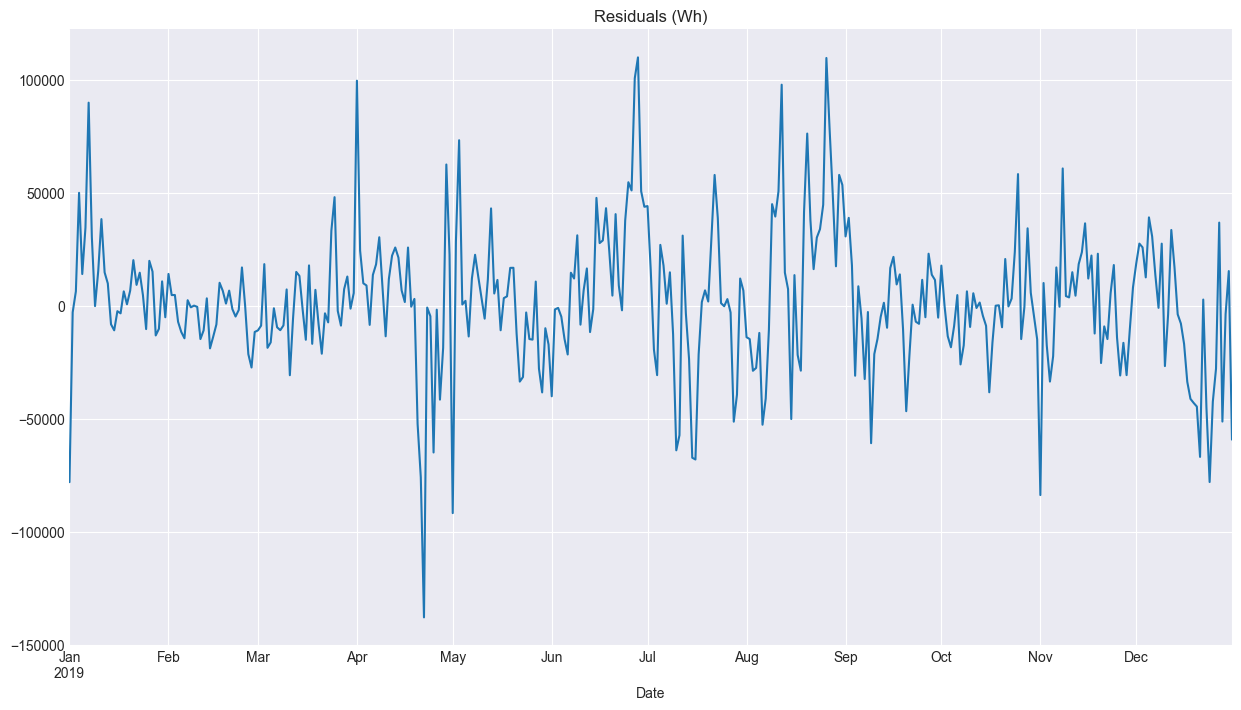

In [113]:
# Compute the residuals
# ==============================================================================
actual_values = data.loc[start_test:, 'Load']
predicted_values = predictions['pred']
residuals = actual_values - predicted_values


# plot the residuals
fig, ax = plt.subplots(figsize=(15, 8))
residuals.plot(ax=ax, label='Load')
ax.set_title('Residuals (Wh)')


The reson behind this might lie in the magnitude of such minimum and maximum values at April and June, respectively. In particular, the minimum power load in April 2019 is also the global minimum in the whole dataset, thus it might be difficult for the model to predict that value. Similarly, only 4 peaks in June throughout the whole dataset (more than 15 years!) reached similar values to that of June 2019. 

The use of steps and lags and their relations with the performance metric need deeper understanding. Moreover, the search space definition and the number of trials in the Bayesian Search seems rather arbitrary as well, and future efforts should be focused on understanding bettert their impact on the performances. Finally, more models can be tested to identify the one that is more suited for the application. In addition, adding exogenous variables (e.g., the air temperature and/or humidity) might improve the model.